# 构建信用卡反欺诈预测模型

## 本项目需解决的问题

本项目通过利用信用卡的历史交易数据，进行机器学习，构建信用卡反欺诈预测模型，提前发现客户**信用卡被盗刷**的事件。

## 建模思路

![1.jpg](./场景解析.jpg)

## 项目背景

数据集包含由欧洲持卡人于2013年9月使用信用卡进行交的数据。此数据集显示两天内发生的交易，其中284,807笔交易中有492笔被盗刷。数据集非常不平衡，
积极的类（被盗刷）占所有交易的0.172％。

它只包含作为PCA转换结果的数字输入变量。不幸的是，由于保密问题，我们无法提供有关数据的原始功能和更多背景信息。特征V1，V2，... V28是使用PCA
获得的主要组件，没有用PCA转换的唯一特征是“时间”和“量”。特征'时间'包含数据集中每个事务和第一个事务之间经过的秒数。特征“金额”是交易金额，此特
征可用于实例依赖的成本认知学习。特征'类'是响应变量，如果发生被盗刷，则取值1，否则为0。
以上取自Kaggle官网对本数据集部分介绍（谷歌翻译），关于数据集更多介绍请参考《[Credit Card Fraud Detection](https://link.zhihu.com/?target=https%3A//www.kaggle.com/dalpozz/creditcardfraud)》。

## 场景解析（算法选择）

1. 首先，我们拿到的数据是持卡人两天内的信用卡交易数据，这份数据包含很多维度，要解决的问题是预测持卡人是否会发生信用卡被盗刷。信用卡持卡人是否会发生被盗刷只有两种可能，发生被盗刷或不发生被盗刷。又因为这份数据是打标好的（字段Class是目标列），也就是说它是一个监督学习的场景。于是，我们判定信用卡持卡人是否会发生被盗刷是一个**二元分类**问题，意味着可以通过二分类相关的算法来找到具体的解决办法，本项目选用的算法是逻辑斯蒂回归（Logistic Regression）。
2. 分析数据：数据是结构化数据 ，不需要做特征抽象。特征V1至V28是经过PCA处理，而特征Time和Amount的数据规格与其他特征差别较大，需要对其做特征缩放，将特征缩放至同一个规格。在数据质量方面 ，没有出现乱码或空字符的数据，可以确定字段Class为目标列，其他列为特征列。
3. 这份数据是全部打标好的数据，可以通过交叉验证的方法对训练集生成的模型进行评估。70%的数据进行训练，30%的数据进行预测和评估。
&emsp&emsp**现对该业务场景进行总结如下：**
1. 根据历史记录数据学习并对信用卡持卡人是否会发生被盗刷进行预测，二分类监督学习场景，选择逻辑斯蒂回归（Logistic Regression）算法。
1. 数据为结构化数据，不需要做特征抽象，但需要做特征缩放。

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('./creditcard.csv')
data.shape

(284807, 31)

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
c = data['Class']
c.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

from sklearn.metrics import roc_curve,auc

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV

# 1数据获取与解析

In [6]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

从上面可以看出，数据为结构化数据，不需要抽特征转化，但特征Time和Amount的数据规格和其他特征不一样，需要对其做特征做特征缩放。

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
standard = StandardScaler()

In [11]:
data['Amount'] = standard.fit_transform(data[['Amount']])

In [12]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [13]:
data['Time']

0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64

In [14]:
data['Time'] = data['Time'].map(lambda x : x//3600)

In [15]:
data['Time']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
284802    47.0
284803    47.0
284804    47.0
284805    47.0
284806    47.0
Name: Time, Length: 284807, dtype: float64

表明此数据有28万行，31列

说明数据类型只有float64和int64，且无缺失值，方便后续处理

# 2特征工程

### 样本均衡问题


![](2.jpg)

In [16]:
# 目标值
y = data['Class']

<AxesSubplot:>

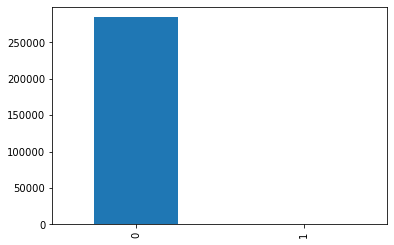

In [19]:
y.value_counts().plot(kind = 'bar')


<AxesSubplot:ylabel='Class'>

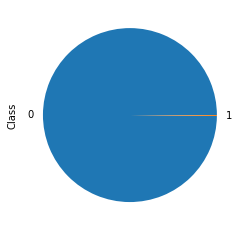

In [20]:
y.value_counts().plot(kind = 'pie')

<AxesSubplot:ylabel='Class'>

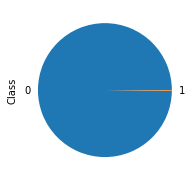

In [21]:
plt.figure(figsize=(3,6))

ax = plt.subplot(1,1,1)
s = y.value_counts()

s.plot(kind='pie')

通过上面的图和数据可知，存在492例盗刷，占总样本的0.17%，由此可知，这是一个明显的数据类别不平衡问题，稍后我们采用过采样(增加数据)的方法对这种问题进行处理。

## 特征转换,将时间从单位每秒化为单位每小时 
### 整除求余divmod

## 特征选择

<AxesSubplot:ylabel='Frequency'>

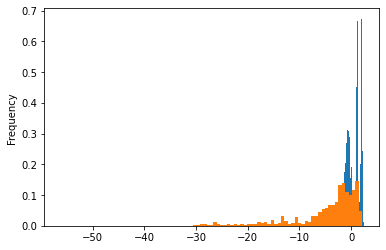

In [26]:
cond_0 = data['Class'] == 0

cond_1 = data['Class'] == 1

data['V1'][cond_0].plot(kind = 'hist',bins = 500,density = True)

data['V1'][cond_1].plot(kind = 'hist',bins = 50,density = True)

In [ ]:
cond_0 = data['Class'] == 0

cond_1 = data['Class'] == 1

plt.figure(figsize=(9,28*6))

for i in range(1,28):

    ax = plt.subplot(28,1,i)
    
    data['V%d'%(i)][cond_0].plot(kind = 'hist',bins = 500,density = True,ax = ax)

    data['V%d'%(i)][cond_1].plot(kind = 'hist',bins = 50,density = True,ax = ax)
    
    ax.set_title('V%d'%(i))

![](3.jpg)

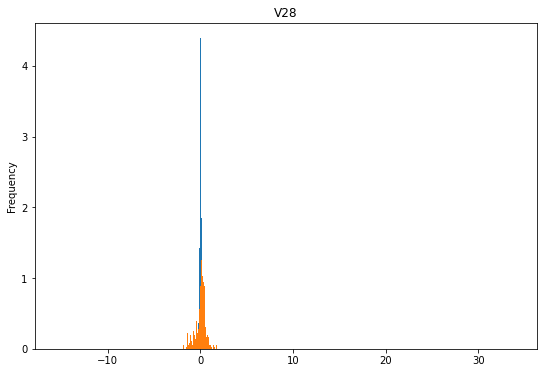

In [46]:
cond_0 = data['Class'] == 0

cond_1 = data['Class'] == 1

plt.figure(figsize=(9,1*6))

for i in range(28,29):
    
    ax = plt.subplot(1,1,1)
    
    data['V%d'%(i)][cond_0].plot(kind = 'hist',bins = 500,density = True,ax = ax)

    data['V%d'%(i)][cond_1].plot(kind = 'hist',bins = 50,density = True,ax = ax)
    
    ax.set_title('V%d'%(i))

#     ax.hist(data['V%d'%(i)][cond_0],bins = 500,density = True)
    
#     ax.hist(data['V%d'%(i)][cond_1],bins = 50,density = True)

In [47]:
# 删除属性 V13，V15，v20，v22，v23，v24，v25，v26，v27，V28

droplabels= ['V13','V15','V20','V22','V23','V24','V25','V26','V27','V28']

data2 = data.drop(droplabels,axis = 1)

In [48]:
data2.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V11,V12,V14,V16,V17,V18,V19,V21,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,-0.018307,0.244964,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,-0.342475,0
2,0.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.247998,1.160686,0
3,0.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,0.140534,0
4,0.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,-0.073403,0


上图是不同变量在信用卡被盗刷和信用卡正常的不同分布情况，我们将选择在不同信用卡状态下的分布有明显区别的变量。因此剔除变量V8、V13 、V15 、V20
、V21 、V22、 V23 、V24 、V25 、V26 、V27 和V28变量。

## 特征缩放

Amount变量和Time变量的取值范围与其他变量相差较大，所以要对其进行特征缩放  
sklearn.preprocessing.StandarScaler

In [49]:
standard = StandardScaler()

data2['Time'] = standard.fit_transform(data2[['Time']])

In [50]:
data2.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V11,V12,V14,V16,V17,V18,V19,V21,Amount,Class
0,-1.960264,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,-0.018307,0.244964,0
1,-1.960264,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,-0.342475,0
2,-1.960264,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.247998,1.160686,0
3,-1.960264,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,0.140534,0
4,-1.960264,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,-0.073403,0


In [51]:
data2.std()

Time      1.000002
V1        1.958696
V2        1.651309
V3        1.516255
V4        1.415869
V5        1.380247
V6        1.332271
V7        1.237094
V8        1.194353
V9        1.098632
V10       1.088850
V11       1.020713
V12       0.999201
V14       0.958596
V16       0.876253
V17       0.849337
V18       0.838176
V19       0.814041
V21       0.734524
Amount    1.000002
Class     0.041527
dtype: float64

## 对特征的重要性进行排序，以进一步减少变量  
### 利用GBDT梯度提升决策树进行特征重要性排序

In [52]:
from sklearn.ensemble import GradientBoostingClassifier

In [53]:
gbdt = GradientBoostingClassifier()

In [54]:
X = data2.iloc[:,:-1]

y = data2['Class']

In [55]:
gbdt.fit(X,y)

GradientBoostingClassifier()

In [56]:
X.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Amount'],
      dtype='object')

In [61]:
argsort = gbdt.feature_importances_.argsort()[::-1]

In [63]:
import numpy as np

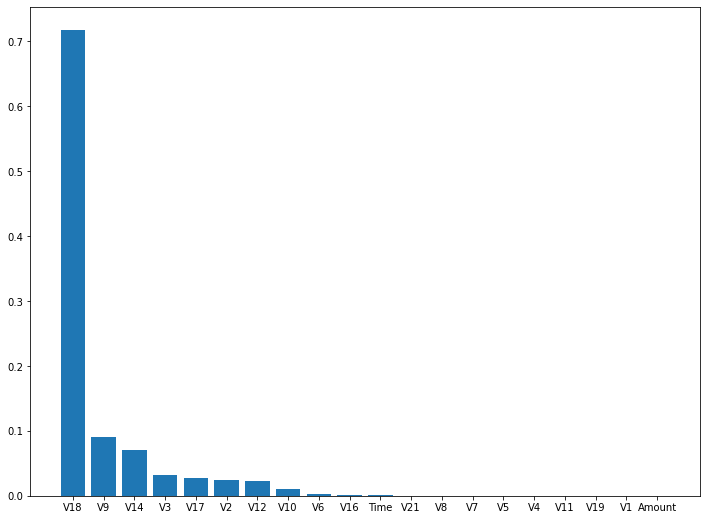

In [64]:
plt.figure(figsize=(12,9))
plt.bar(np.arange(20),gbdt.feature_importances_[argsort])

_ = plt.xticks(np.arange(20),X.columns[argsort])

In [65]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [66]:
X2 = SelectKBest(chi2, k=15).fit_transform(X, y) #抱錯

ValueError: Input X must be non-negative.

In [71]:
corr = data2.corr().loc[['Class']]
corr.iloc[:,:10]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9
Class,-0.012326,-0.101347,0.091289,-0.192961,0.133447,-0.094974,-0.043643,-0.187257,0.019875,-0.097733


In [72]:
corr.iloc[:,10:]

,V10,V11,V12,V14,V16,V17,V18,V19,V21,Amount,Class
Class,-0.216883,0.154876,-0.260593,-0.302544,-0.196539,-0.326481,-0.111485,0.034783,0.040413,0.005632,1.0


In [73]:
droplabels = ['Amount','V19','Time','V21','V8']

In [74]:
X.drop(droplabels,axis = 1,inplace=True)

In [75]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195


https://www.youtube.com/watch?v=EklIBuqqUfM&list=PLwDQt7s1o9J65aQ6HYN4LaqRkX8ncKG1D&index=127

# 模型训练
**处理样本不平衡问题**

目标变量“Class”正常和被盗刷两种类别的数量差别较大，会对模型学习造成困扰。举例来说，假如有100个样本，其中只有1个是被盗刷样本，其余99个全为正常样本，那么学习器只要制定一个简单的方法：即判别所有样本均为正常样本，就能轻松达到99%的准确率。而这个分类器的决策对我们的风险控制毫无意义。因此，在将数据代入模型训练之前，我们必须先解决样本不平衡的问题。
**现对该业务场景进行总结如下：**
1. 过采样（oversampling），增加正样本使得正、负样本数目接近，然后再进行学习。
2. 欠采样（undersampling），去除一些负样本使得正、负样本数目接近，然后再进行学习。
本次处理样本不平衡采用的方法是**过采样**，具体操作使用SMOTE（Synthetic Minority Oversampling Technique），SMOET的基本原理是：采样最邻近算法，计算出每个少数类样本的K个近邻，从K个近邻中随机挑选N个样本进行随机线性插值，构造新的少数样本，同时将新样本与原数据合成，产生新的训练集。更详细说明参考CMU关于SMOTE: [Synthetic Minority Over-sampling Technique](http://link.zhihu.com/?target=http%3A//www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/chawla2002.html)的介绍。

# SMOTE过采样

In [76]:
smote = SMOTE()


In [77]:
X2,y2 = smote.fit_resample(X,y)

In [79]:
X2.shape

(568630, 15)

In [82]:
(y2 ==0).sum()

284315

In [83]:
(y2 ==1).sum()

284315

# 自定义可视化函数

In [92]:
# for 循环
import itertools
# 画图方法
# 绘制真实值和预测值对比情况
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar(shrink = 0.5)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")#若对应格子上面的数量不超过阈值则，上面的字体为白色，为了方便查看

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 单独的逻辑回归求得查全率Recall rate  
# Recall也叫召回率


In [93]:
from sklearn.model_selection import train_test_split

In [94]:
X_train,X_test,y_train,y_test = train_test_split(X2,y2,test_size = 0.1)

In [95]:
lg = LogisticRegression()

lg.fit(X_train,y_train)

LogisticRegression()

In [96]:
lg.score(X_test,y_test)

0.9352654626030987

In [97]:
prob_ = lg.predict_proba(X_test)
prob_

array([[9.28858867e-01, 7.11411332e-02],
       [4.05851199e-01, 5.94148801e-01],
       [9.71845090e-01, 2.81549103e-02],
       ...,
       [2.39314912e-04, 9.99760685e-01],
       [2.08155353e-01, 7.91844647e-01],
       [9.94774883e-01, 5.22511674e-03]])

In [98]:
y_ = lg.predict(X_test)
y_

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

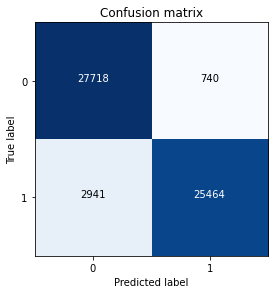

In [100]:
cm = confusion_matrix(y_test,y_)
plot_confusion_matrix(cm,classes=[0,1])

# 利用GridSearchCV进行交叉验证和模型参数自动调优

In [101]:

lg = LogisticRegression()

clf = GridSearchCV(lg,param_grid={'C':[0.1,0.5,1.0,10,100]})

clf.fit(X_train,y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.5, 1.0, 10, 100]})

In [102]:
clf.best_score_

0.936156493830844

In [103]:
clf.best_params_

{'C': 0.5}

# 预测

In [105]:
clf.score(X_test,y_test)

0.9352654626030987

In [106]:
prob_ = clf.predict_proba(X_test)[:,-1]

# 结果可视化  
## 对比逻辑斯蒂回归和GridSearchCV结果

# 模型评估

解决不同的问题，通常需要不同的指标来度量模型的性能。例如我们希望用算法来预测癌症是否是恶性的，假设100个病人中有5个病人的癌症是恶性，
对于医生来说，尽可能提高模型的**查全率（recall）比提高查准率（precision）**更为重要，因为站在病人的角度，**发生漏发现癌症为恶性比发生误
判为癌症是恶性更为严重。**

由此可见就上面的两个算法而言，明显lgb过拟合了，考虑到样本不均衡问题，故应该选用简单一点的算法（逻辑回归）来减少陷入过拟合的陷阱。

## 考虑设置阈值，来调整预测被盗刷的概率，依次来调整模型的查全率（Recall）

In [107]:
threshold = np.arange(0.05,1.01,0.05)
threshold

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [108]:
threshold.size

20

threshold:0.0500,score：0.7644,Recall:0.9945
threshold:0.1000,score：0.8745,Recall:0.9826
threshold:0.1500,score：0.9070,Recall:0.9649
threshold:0.2000,score：0.9228,Recall:0.9513
threshold:0.2500,score：0.9307,Recall:0.9400
threshold:0.3000,score：0.9335,Recall:0.9272
threshold:0.3500,score：0.9345,Recall:0.9161
threshold:0.4000,score：0.9357,Recall:0.9092
threshold:0.4500,score：0.9362,Recall:0.9033
threshold:0.5000,score：0.9353,Recall:0.8965
threshold:0.5500,score：0.9340,Recall:0.8903
threshold:0.6000,score：0.9338,Recall:0.8865
threshold:0.6500,score：0.9344,Recall:0.8840
threshold:0.7000,score：0.9348,Recall:0.8818
threshold:0.7500,score：0.9345,Recall:0.8794
threshold:0.8000,score：0.9338,Recall:0.8761
threshold:0.8500,score：0.9307,Recall:0.8684
threshold:0.9000,score：0.9285,Recall:0.8621
threshold:0.9500,score：0.9267,Recall:0.8557
threshold:1.0000,score：0.5162,Recall:0.0315


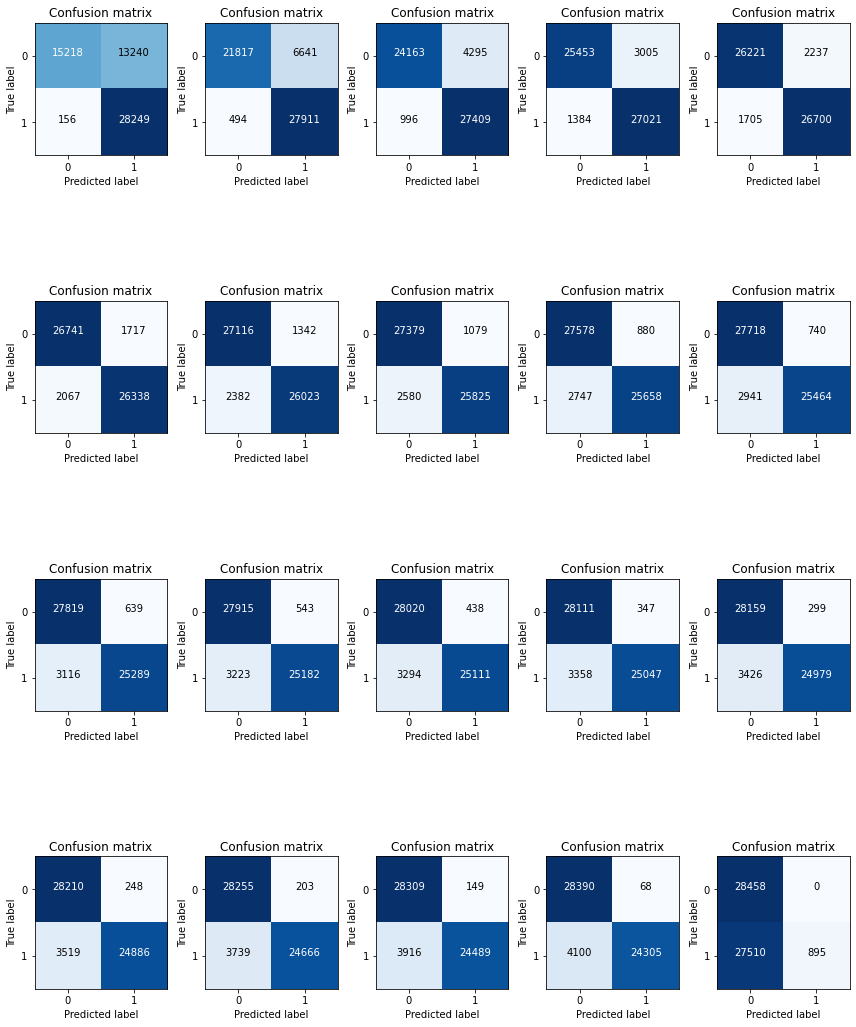

In [110]:
plt.figure(figsize=(12,20))

recall = []

accuracy = []

for i,t in enumerate(threshold):
    
    y_ = (prob_ >= t).astype(np.int8)
    
#     y_test
    cm = confusion_matrix(y_test,y_)
    print('threshold:%0.4f,score：%0.4f,Recall:%0.4f'%(t,(cm[0,0] + cm[1,1])/cm.sum(),cm[1,1]/cm[1].sum()))
    
    recall.append(cm[1,1]/cm[1].sum())
    
    accuracy.append((cm[0,0] + cm[1,1])/cm.sum())
    
    plt.subplot(5,5,i+1)
    plot_confusion_matrix(cm,classes=[0,1])

# 趋势图

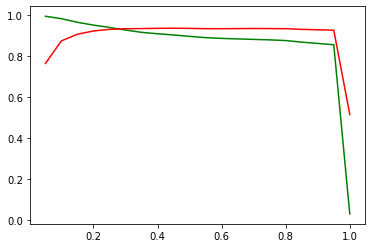

In [111]:
plt.plot(threshold,recall,color = 'green')

plt.plot(threshold,accuracy,color = 'red')

由上图所见，随着阈值逐渐变大，Recall rate逐渐变小，Precision rate逐渐变大，AUC值先增后减

# 找出模型最优的阈值

precision和recall是一组矛盾的变量。从上面混淆矩阵和PRC曲线可以看到，阈值越小，recall值越大，模型能找出信用卡被盗刷的数量也就更多，但换来的代价是误判的数量也较大。随着阈值的提高，recall值逐渐降低，precision值也逐渐提高，误判的数量也随之减少。**通过调整模型阈值，控制模型反信用卡欺诈的力度，若想找出更多的信用卡被盗刷就设置较小的阈值，反之，则设置较大的阈值。**
实际业务中，阈值的选择取决于公司业务边际利润和边际成本的比较；当模型阈值设置较小的值，确实能找出更多的信用卡被盗刷的持卡人，但随着误判数量增加，不仅加大了贷后团队的工作量，也会降低正常情况误判为信用卡被盗刷客户的消费体验，从而导致客户满意度下降，如果某个模型阈值能让业务的**边际利润和边际成本达到平衡时，则该模型的阈值为最优值**。当然也有例外的情况，发生金融危机，往往伴随着贷款违约或信用卡被盗刷的几率会增大，而金融机构会更愿意设置小阈值，不惜一切代价守住风险的底线。